##Import Libraries

In [10]:
# Library to support working with data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from functools import partial
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from functools import partial
from keras.layers import GRU, Dropout, Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error

##Data preprocessing

###Read data

In [11]:
# Load data
df = pd.read_csv('./data/CTLT.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,30.860001,31.260000,30.240000,30.910000,30.910000,1201700
1,2019-01-03,30.660000,30.660000,29.290001,29.840000,29.840000,1149900
2,2019-01-04,30.049999,31.360001,29.940001,31.080000,31.080000,3530400
3,2019-01-07,31.020000,32.180000,30.850000,32.000000,32.000000,1063400
4,2019-01-08,32.340000,33.060001,32.150002,32.790001,32.790001,1391000
...,...,...,...,...,...,...,...
1114,2023-06-06,37.910000,39.049999,37.580002,38.820000,38.820000,2261700
1115,2023-06-07,39.160000,40.029999,38.250000,39.959999,39.959999,4382500
1116,2023-06-08,39.700001,39.840000,36.750000,39.000000,39.000000,9705500
1117,2023-06-09,39.250000,40.110001,38.480000,38.810001,38.810001,4493800


###Reset index

In [12]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [13]:
# Select the Close column as the dependent variable
df_Close = df[['Close']]
#df_Close = df_Close.dropna() # Drop missing values
df_Close = df_Close.reset_index(drop=True) # Reset the index
df_Close.head(20)

,Close
0,30.910000
1,29.840000
2,31.080000
3,32.000000
4,32.790001
5,33.380001
6,33.880001
7,33.750000
8,33.590000
9,34.070000


###Data normalization

In [14]:
# Scaling the data
scaler=MinMaxScaler(feature_range=(0,1))
data_scaled=scaler.fit_transform(df_Close)
data_scaled

array([[0.00951027],
       [0.        ],
       [0.01102124],
       ...,
       [0.08141498],
       [0.07972625],
       [0.11501198]])

###Data splitting

In [15]:
# Split the data into training, validation and test dataset in a ratio of 7:1:2
train_size = int(0.7 * len(data_scaled))
val_size = int(0.1 * len(data_scaled))
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

###Define Model and find the Best Model on the Training and Validation Sets

In [16]:
#define
units_values = [50, 100, 150, 200]
dropout_values = [0.1, 0.2, 0.3, 0.4, 0.5]
optimizer_values = ['adam', 'rmsprop', 'sgd']

#define param_distributions
param_distributions = {
    'units': units_values,
    'dropout': dropout_values,
    'optimizer': optimizer_values
}

#define time_step
time_step_grid = [30, 50, 60, 70, 100]

best_mape = float('inf')
best_model = None
best_params = None
best_time_step = None

In [17]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step, prev_data=None):
    dataX, dataY = [], []
    start_index = 0

    # If previous data is available
    if prev_data is not None:
        start_index = max(0, time_step - len(prev_data))
        dataset = np.concatenate((prev_data, dataset))

    for i in range(start_index, len(dataset)-time_step):
        dataX.append(dataset[i:(i+time_step), 0])
        dataY.append(dataset[i + time_step, 0])

    return np.array(dataX), np.array(dataY)


In [18]:
def create_model(time_step, units, dropout, optimizer):
    # Define GRU model with current parameters
    model = Sequential()
    model.add(GRU(units, input_shape=(time_step, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [19]:
for time_step in time_step_grid:
    print(f"Starting evaluation for time_step: {time_step}")

    X_train, y_train = create_dataset(train_data, time_step)
    last_points_train = train_data[-time_step:]
    X_val, y_val = create_dataset(val_data, time_step, last_points_train)


    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

    model = KerasRegressor(build_fn=create_model, time_step=time_step, epochs=100, batch_size=64, verbose=0)

    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_iter=10, cv=3)
    random_search.fit(X_train, y_train)

    current_model = random_search.best_estimator_.model

    # early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    current_model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping])

    predictions = current_model.predict(X_val)
    mape = mean_absolute_percentage_error(y_val, predictions)

    print(f"Validation MAPE for time_step {time_step}: {mape}")
    print(f"Best parameters for time_step {time_step}: {random_search.best_params_}")

    if mape < best_mape:
        best_mape = mape
        best_model = current_model
        best_params = random_search.best_params_
        best_time_step = time_step
# Print the best overall parameters and score.
print("---------------------------------------")
print(f"Best overall MAPE: {best_mape}")
print(f"Best overall parameters: {best_params}")
print(f"Best overall time_step: {best_time_step}")

Starting evaluation for time_step: 30
4/4 [==============================] - 0s 3ms/step
Validation MAPE for time_step 30: 0.04515605294315277
Best parameters for time_step 30: {'units': 150, 'optimizer': 'adam', 'dropout': 0.3}
Starting evaluation for time_step: 50
4/4 [==============================] - 0s 4ms/step
Validation MAPE for time_step 50: 0.03436462436629025
Best parameters for time_step 50: {'units': 200, 'optimizer': 'adam', 'dropout': 0.2}
Starting evaluation for time_step: 60
4/4 [==============================] - 1s 6ms/step
Validation MAPE for time_step 60: 0.03607605921128328
Best parameters for time_step 60: {'units': 200, 'optimizer': 'rmsprop', 'dropout': 0.3}
Starting evaluation for time_step: 70
4/4 [==============================] - 0s 4ms/step
Validation MAPE for time_step 70: 0.032067073343226817
Best parameters for time_step 70: {'units': 150, 'optimizer': 'adam', 'dropout': 0.3}
Starting evaluation for time_step: 100
4/4 [==============================] - 0s

###Trainning the model with the best parameters.

In [20]:
# Create training, validation and test datasets with the best time_step
X_train, y_train = create_dataset(train_data, best_time_step)
X_val, y_val = create_dataset(val_data, best_time_step)

last_points_val = val_data[-best_time_step:]
X_test, y_test = create_dataset(test_data, best_time_step, last_points_val)
# Reshape input to be [samples, time steps, features] which is required for GRU
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

###Training process

In [21]:
# Create a new model with the best parameters
best_model = create_model(best_time_step, best_params['units'], best_params['dropout'], best_params['optimizer'])

In [22]:
# Define early stopping
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [23]:
# Train the model with the full training data (train + validation)
best_model.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)), epochs=100, batch_size=64, verbose=1, callbacks=[early_stopping])

Epoch 1/100
12/12 [==============================] - 5s 11ms/step - loss: 0.1042
Epoch 2/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0148
Epoch 3/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0099
Epoch 4/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0057
Epoch 5/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0040
Epoch 6/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0031
Epoch 7/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0029
Epoch 8/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0028
Epoch 9/100
12/12 [==============================] - 0s 10ms/step - loss: 0.0027
Epoch 10/100
12/12 [==============================] - 0s 12ms/step - loss: 0.0026
Epoch 11/100
12/12 [==============================] - 0s 12ms/step - loss: 0.0025
Epoch 12/100
12/12 [==============================] - 0s 12ms/step - loss: 0.0026
Epoch 13/100
12/12 [=======

In [24]:
# Now use this to make predictions
y_pred_test = best_model.predict(X_test)

8/8 [==============================] - 0s 3ms/step


###Testing process

In [25]:
# Invert scaling
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test)

In [26]:
test_MAPE = mean_absolute_percentage_error(y_test_inv, y_pred_test_inv)
test_RMSE = mean_squared_error(y_test_inv, y_pred_test_inv, squared=False)
test_MSLE = mean_squared_log_error(y_test_inv, y_pred_test_inv)
print('MAPE on the data test:', test_MAPE)
print('RMSE on the data test', test_RMSE)
print('MSLE on the data test', test_MSLE)

MAPE on the data test: 0.042925818608062626
RMSE on the data test 3.6280510703416824
MSLE on the data test 0.0041967520966966505


##Predicting the next 30 days

In [27]:
# Convert the last `best_time_step` days of the test data into the appropriate shape for input to the model
x_input = test_data[-best_time_step:].reshape(1, -1, 1)

temp_input = list(x_input[0])

lst_output = []
i = 0
while(i < 30):
    if len(temp_input) > best_time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1, 1)
        y_pred = best_model.predict(x_input)
        print("{} day input {}".format(i, x_input))
        print("{} day output {}".format(i, y_pred))
        temp_input.append(y_pred[0][0])
        temp_input = temp_input[1:]
        lst_output.append(y_pred[0][0])
        i += 1
    else:
        x_input = np.array(temp_input, dtype=np.float32).reshape((1, len(temp_input), 1))
        y_pred = best_model.predict(x_input)
        print("{} day input {}".format(i, x_input))
        print("{} day output {}".format(i, y_pred))
        temp_input.append(y_pred[0][0])
        temp_input = temp_input[1:]
        lst_output.append(y_pred[0][0])
        i += 1


1/1 [==============================] - 0s 22ms/step
0 day input [[[0.39480934]
  [0.36885604]
  [0.33748108]
  [0.35507953]
  [0.35641277]
  [0.33845878]
  [0.31846055]
  [0.35970134]
  [0.35552388]
  [0.36761174]
  [0.33125943]
  [0.330104  ]
  [0.32832634]
  [0.30939472]
  [0.29152963]
  [0.3060172 ]
  [0.3348147 ]
  [0.3206826 ]
  [0.32948184]
  [0.30957246]
  [0.31881607]
  [0.29401827]
  [0.28806326]
  [0.28246376]
  [0.3120611 ]
  [0.33259267]
  [0.31641632]
  [0.30583948]
  [0.29748467]
  [0.14647587]
  [0.13856545]
  [0.10879034]
  [0.11758954]
  [0.12941073]
  [0.13501021]
  [0.13421027]
  [0.111279  ]
  [0.12345569]
  [0.15207537]
  [0.18025063]
  [0.18025063]
  [0.16780731]
  [0.16887386]
  [0.17234023]
  [0.15918584]
  [0.0499511 ]
  [0.04621812]
  [0.03333037]
  [0.03866322]
  [0.02684207]
  [0.02977512]
  [0.01795397]
  [0.02026485]
  [0.02044262]
  [0.06514975]
  [0.06817169]
  [0.07368235]
  [0.06754954]
  [0.06257222]
  [0.06470535]
  [0.05848367]
  [0.06568304]
  [0.0

In [28]:
# Invert the scaling
lst_output = scaler.inverse_transform(np.array(lst_output).reshape(-1,1))

print('Predicted closing prices for the next 30 days:')
for i in range(30):
    print(f"{lst_output[i][0]}")

Predicted closing prices for the next 30 days:
40.777137756347656
41.32979202270508
41.630496978759766
41.84488296508789
42.02256774902344
42.18150329589844
42.32963562011719
42.47110366821289
42.6082649230957
42.742576599121094
42.87495803833008
43.006019592285156
43.13616180419922
43.26566696166992
43.39471435546875
43.523441314697266
43.65194320678711
43.78026580810547
43.908470153808594
44.03657531738281
44.16460037231445
44.292564392089844
44.42047119140625
44.5483283996582
44.6761360168457
44.80390167236328
44.93162155151367
45.059295654296875
45.186920166015625
45.31449508666992


##Visualization

In [29]:
# Create a date index for the predicted data
predict_data_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)

In [30]:
# Before Plotting Data
# Create index for the training, validation and test data
train_data_index = df.index[:train_size]
val_data_index = df.index[train_size : train_size + val_size]
test_data_index = df.index[train_size + val_size:]

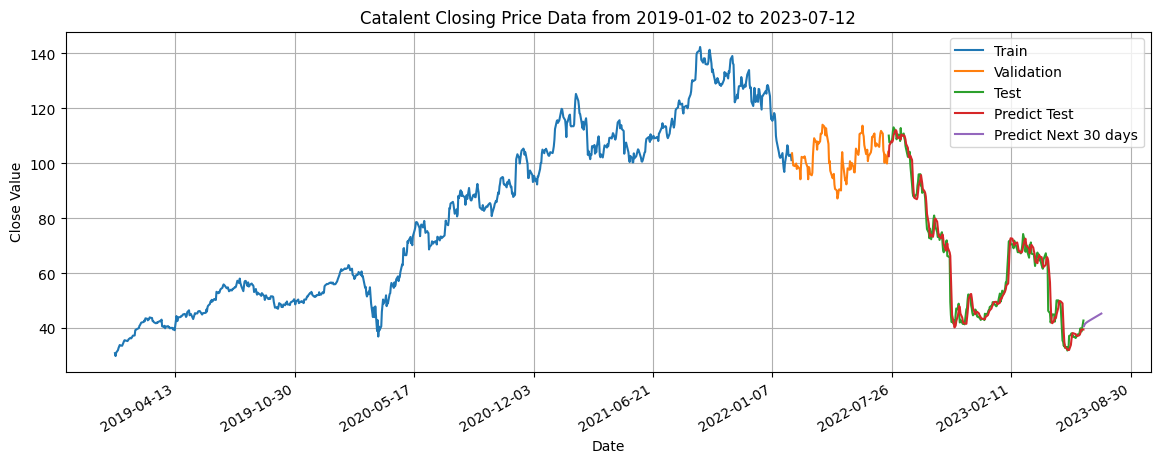

In [31]:
# Begin Plotting Data
plt.figure(figsize=(14, 5))
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')
plt.plot(val_data_index, scaler.inverse_transform(val_data), label='Validation')
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')
plt.plot(test_data_index, y_pred_test_inv, label='Predict Test')
plt.plot(predict_data_index, lst_output, label='Predict Next 30 days')

# Set up the date markers on the x-axis
plt.grid()
plt.title(f"Catalent Closing Price Data from {train_data_index[0].strftime('%Y-%m-%d')} to {predict_data_index[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close Value")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=200)) # Select markers spaced 200 days apart
plt.gcf().autofmt_xdate() # Rotate date labels for better readability
plt.legend()
plt.savefig('./GRU/7_1_2/Image/GRU_712_CTLT.png')
plt.show()
